In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [3]:
import numpy as np
import quicklens as ql
import healpy as hp
import matplotlib.pyplot as plt

IMPORT ERROR: /global/homes/a/ab2368/.conda/envs/myenv_fixed/lib/python2.7/site-packages/quicklens/mpi.pyc (No module named pypar). Could not load pbs or pypar. MPI will not be used.


Load noiseless sims of SO LAT observations for the purpose of testing phi reconstruction

In [ ]:
simid = 0

filedir = '/project/projectdirs/sobs/v4_sims/mbs/'
nside_of_sim = 4096
sim_component = 'cmb'#'cmb' #'noise' #'dust' #'synchrotron'
which_tel = 'la' #'la'
simid = ('%04d' % simid)
freq = '039'#'027' #'039' #'093' #'145' #'225' #'280'
filename = filedir+'201901_gaussian_fg_lensed_cmb_realistic_noise/'+str(nside_of_sim)+'/'+sim_component+'/'+simid+'/simonsobs_'+sim_component+'_uKCMB_'+which_tel+freq+'_nside'+str(nside_of_sim)+'_'+simid+'.fits'

T_map = hp.read_map(filename, field=0)
Q_map = hp.read_map(filename, field=1)
U_map = hp.read_map(filename, field=2)

Obtain TEB from TQU via spherical harmonic transforms

In [ ]:
lmax = 500
Talm_beamconv, Ealm_beamconv, Balm_beamconv = hp.map2alm([T_map, Q_map, U_map], lmax=lmax)

Deconvolve the beam

In [ ]:
#At 145GHz, the beam FWHM is approximately 1,4 arcmin
beam_fwhm_arcmin = 1.4

bl = ql.spec.bl(beam_fwhm_arcmin, lmax)
beam = ql.spec.clmat_teb( ql.util.dictobj( {'lmax' : lmax, 'cltt' : bl, 'clee' : bl, 'clbb' : bl} ) )

Talm = ql.spec.deconvolve_beam_from_alms(Talm_beamconv, bl)
Ealm = ql.spec.deconvolve_beam_from_alms(Ealm_beamconv, bl)
Balm = ql.spec.deconvolve_beam_from_alms(Balm_beamconv, bl)

Proceed with the (diagonal) inverse-variance filtering

In [ ]:
cl_unl     = ql.spec.get_camb_scalcl(fname='/project/projectdirs/cmb/data/generic/cmb/ffp10/cls/ffp10_scalCls.dat', lmax=lmax)
cl_len     = ql.spec.get_camb_lensedcl(fname='/project/projectdirs/cmb/data/generic/cmb/ffp10/cls/ffp10_lensedCls.dat', lmax=lmax)
cl_theory  = ql.spec.clmat_teb( ql.util.dictobj( {'lmax' : lmax, 'cltt' : cl_len.cltt, 'clee' : cl_len.clee, 'clbb' : cl_len.clbb} ) )

#We work with noiseless sims, but you can include noise here
nlev_t = nlev_p = 0.0

ivf_lib = ql.sims.ivf.library_diag_full_sky(cl_theory, beam, nlev_t=nlev_t, nlev_p=nlev_p)

#If you use an EB quadratic estimator to delens B, you'll want to introduce a minimum ell cutoff to avoid bias below it
lcut_for_Bmodes = 0 #100

t_alm_filtered = ivf_lib.ivf_alm_array(Talm, 'cltt')
e_alm_filtered = ivf_lib.ivf_alm_array(Ealm, 'clee')
b_alm_filtered = ivf_lib.ivf_alm_array(Balm, 'clbb', lcut_for_Bmodes)

Initialize the quadratic estimators

In [37]:
npad       = 1
qest_lib = ql.sims.qest.library(cl_unl, cl_len, ivf_lib, npad=npad)

Compute the (unnormalized) quadratic estimator

In [ ]:
estimated_qft_vlm = qest_lib.get_qft_full_sky('peb', t_alm_filtered, e_alm_filtered, b_alm_filtered, t_alm_filtered, e_alm_filtered, b_alm_filtered)
g_alm, c_alm = ql.shts.util.vlm2alm(estimated_qft_vlm)

Normalize it

In [ ]:
norm = qest_lib.get_qr_full_sky('peb')
normed_rec = hp.sphtfunc.almxfl(g_alm, np.nan_to_num(1./norm))

nside_out = 256
rec_map_EB = hp.sphtfunc.alm2map(normed_rec, nside_out, lmax=lmax, pol=False)

And finally, here is our estimate of $\phi$

/global/homes/a/ab2368/.conda/envs/myenv_fixed/lib/python2.7/site-packages/quicklens/qest/lens.py:279: RuntimeWarning: invalid value encountered in sqrt
  return np.interp( l, np.arange(0, len(self.clee)), self.clee, right=0 ) * np.nan_to_num( np.sqrt( (l+3.)*(l-2.) ) )
/global/homes/a/ab2368/.conda/envs/myenv_fixed/lib/python2.7/site-packages/quicklens/qest/lens.py:277: RuntimeWarning: invalid value encountered in sqrt
  return np.interp( l, np.arange(0, len(self.clee)), self.clee, right=0 ) * np.nan_to_num( np.sqrt( (l+2.)*(l-1.) ) )
/global/homes/a/ab2368/.conda/envs/myenv_fixed/lib/python2.7/site-packages/quicklens/qest/qest.py:163: ComplexWarning: Casting complex values to real discards the imaginary part
  ret[L] += clL[L] * qeXY.wl[i][2](L) * cfunc_ZA( qeZA.wl[j][2](L) ) / (32.*np.pi)
/global/u1/a/ab2368/.conda/envs/myenv_fixed/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
monopole: -1.39647e-11  dipole: lon: 111.922, lat: -0.209195, amp: 0.0309695


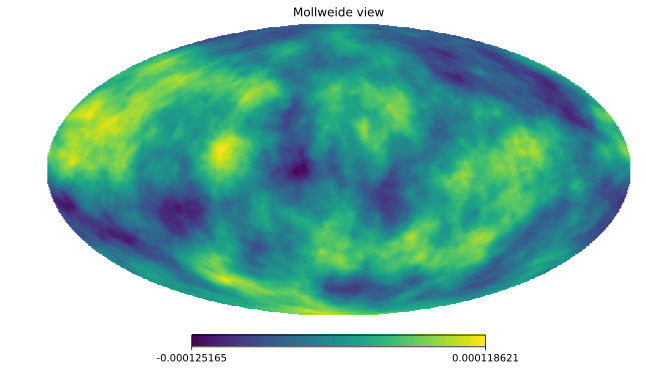

In [39]:
hp.mollview(rec_map_EB, cbar=True, remove_dip=True)

We can compare this to the input $\phi$

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


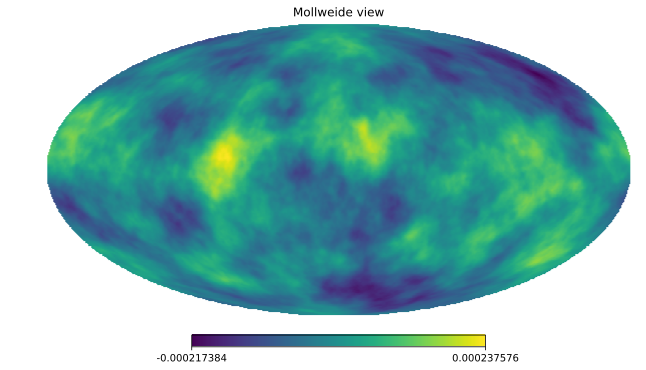

In [42]:
def read_phi_alms(idx):
    phi_alm_file = '/global/cscratch1/sd/engelen/simsS1516_v0.4/data/fullskyPhi_alm_'+ ('%05d' % idx) +'.fits'
    phi_alm = hp.read_alm(phi_alm_file)
    return phi_alm

phi_alm_realiz = read_phi_alms(int(simid))
phi_map_realiz = hp.alm2map(phi_alm_realiz.astype('complex'), nside=nside_out)
hp.mollview(phi_map_realiz, remove_dip=False)

More quantitatively, we cross-correlate them making sure to convert them to $\kappa$ first

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


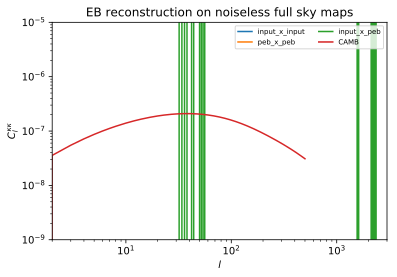

In [44]:
def convert_phi_to_kappa(phi_map, ls, lmax, nside_out):
    phi_alm = hp.map2alm(phi_map, lmax=lmax, pol=False)
    kappa_alm = hp.sphtfunc.almxfl(phi_alm, 0.5*ls**2)
    kappa_map = hp.alm2map(kappa_alm, nside_out)
    return kappa_map

ells=np.arange(lmax+1)

true_kappa = convert_phi_to_kappa(phi_map_realiz, ells, lmax, nside_out)
true_x_true = hp.anafast(true_kappa, lmax=lmax, pol=False)

rec_kappa_map_EB = convert_phi_to_kappa(rec_map_EB, ells, lmax, nside_out)
peb_x_peb = hp.sphtfunc.anafast(rec_kappa_map_EB, lmax=lmax, pol=False)
true_x_peb = hp.sphtfunc.anafast(true_kappa, rec_kappa_map_EB, lmax=lmax, pol=False)

plt.loglog(ells, true_x_true, label='input_x_input')
plt.loglog(ells, peb_x_peb, label='peb_x_peb')
plt.loglog(ells, true_x_peb, label='input_x_peb')

plt.loglog(cl_unl.ls, (1.0/4)*cl_unl.clpp*cl_unl.ls**4, label=r'CAMB')

plt.title('EB reconstruction on noiseless full sky maps')
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l^{\kappa\kappa}$')
plt.ylim([1e-9, 1e-5])
plt.xlim([2,3000])
plt.legend(fontsize=7, ncol=2)